In [1]:
import json
import string
import pandas as pd

In [2]:
refined_categ = ['coreference', 
         'event misordering',
         'lack of commonsense knowledge',
         'fail to understand idiom',
         'manner',
         'modality',
         'misattribution',
         'missed detail',
         'quantity',
         'quality',
         'world knowledge',
         'wrong verb',
         'wrong word sense']

def read_data(json_files):
    all_data = []
    for filename in json_files:
        with open(filename, 'r') as fp:
            model_name= 'Alpaca' if 'alpaca' in filename else 'GPT'
            all_data.append((model_name, json.load(fp)))
    return all_data
    
def make_df(all_file_data):
    annotation_categs = []
    annotation_err_type = []
    for model_name, all_data in all_file_data:
        print(len(all_data))
        for data in all_data:
            err_type = data['target'].split('\n')[1].split('ERROR TYPE:')[-1].strip()
            err_type = err_type if err_type!= 'None' else 'Intrinsic_Error'
            for edits in data['edits']:
                    categ = edits['annotation'].values()
                    for ann in categ:
                        added = False
                        if ann == 'missing detail':
                            ann = 'missed detail'
                        for ref in refined_categ:
                            ref = ref.split(string.punctuation)[0].strip()
                            if ref in ann or ref == ann:
                                added = True
                                annotation_categs.append((err_type,ref, model_name))
                                # annotation_err_type.append(err_type)
                                break
        print(len(annotation_categs))
                        
    df_plot = {
    'model_name': [],
    'category': [],
    'err_type': []
    }
    
    for categ in annotation_categs:
        df_plot['category'].append(categ[1])
        df_plot['err_type'].append(categ[0])
        df_plot['model_name'].append(categ[2])
    return pd.DataFrame(df_plot)

In [3]:
all_data = read_data(['annotations-gpt.json', 'annotations-alpaca.json'])
df_all_data = make_df(all_data)
df_all_data

88
85
181
166


,model_name,category,err_type
0,GPT,coreference,Intrinsic_Error
1,GPT,coreference,Extrinsic_Error
2,GPT,quantity,Extrinsic_Error
3,GPT,quantity,Extrinsic_Error
4,GPT,world knowledge,Intrinsic_Error
...,...,...,...
161,Alpaca,quantity,Extrinsic_Error
162,Alpaca,coreference,Intrinsic_Error
163,Alpaca,lack of commonsense knowledge,Intrinsic_Error
164,Alpaca,lack of commonsense knowledge,Intrinsic_Error


In [17]:
model_map = {'models': [],
            'err_type': [],
            'categ_count': []}

unique_error_types = list(set(df_all_data['err_type'].values))
unique_categories = set(df_all_data['category'].values)
for err_type in unique_error_types:
    df_err_type = df_all_data[df_all_data['err_type'] == err_type]
    for model_name in ['GPT', 'Alpaca']:
        df_model_err_type = df_err_type[df_err_type['model_name'] == model_name]
        
        print(model_name, err_type, len(df_model_err_type))
        for categ in unique_categories:
            df_model_err_type_categ = df_model_err_type[df_model_err_type['category'] == categ]
            if 'categ' not in model_map:
                model_map['categ'] = []
            model_map['categ'].append(categ)
            model_map['categ_count'].append(len(df_model_err_type_categ))
            model_map['models'].append(model_name)
            model_map['err_type'].append(err_type)
            

GPT Intrinsic_Error 37
Alpaca Intrinsic_Error 57
GPT Extrinsic_Error 48
Alpaca Extrinsic_Error 24


In [13]:
model_map = pd.DataFrame(model_map)
model_map.head()

,models,err_type,categ_count,categ
0,GPT,Intrinsic_Error,1,fail to understand idiom
1,GPT,Intrinsic_Error,2,wrong word sense
2,GPT,Intrinsic_Error,0,lack of commonsense knowledge
3,GPT,Intrinsic_Error,4,missed detail
4,GPT,Intrinsic_Error,0,modality


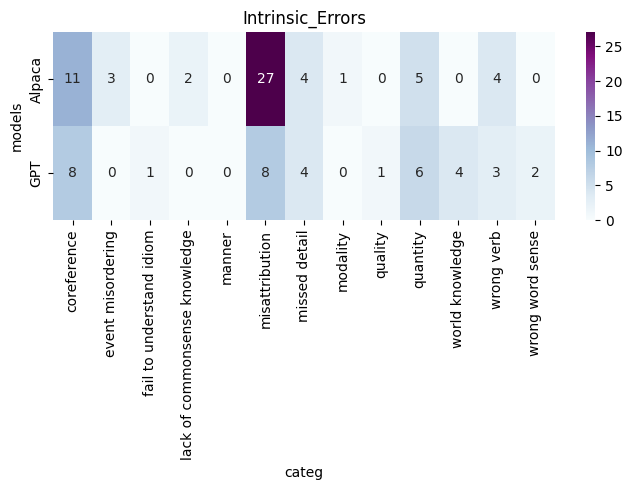

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
model_map_intr = model_map[model_map['err_type'] == 'Intrinsic_Error']
# model_map_intr = model_map_intr.set_index('models')
model_map_intr = model_map_intr.pivot(index="models", columns="categ", values="categ_count")

plt.figure(figsize=(7, 5))
# glue = sns.load_dataset("glue").pivot(index="Model", columns="Task", values="Score")
# glue
ax = sns.heatmap(model_map_intr, cmap="BuPu", annot = True)
ax.set_title('Intrinsic_Errors')
plt.tight_layout()
plt.savefig('intrinsic_categories.pdf')

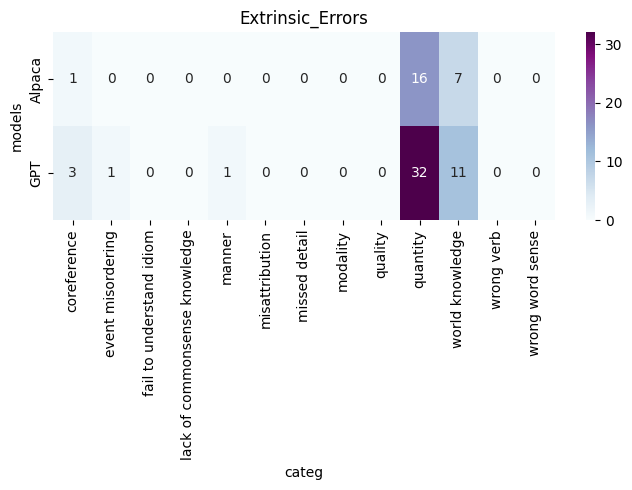

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
model_map_intr = model_map[model_map['err_type'] == 'Extrinsic_Error']
# model_map_intr = model_map_intr.set_index('models')
model_map_intr = model_map_intr.pivot(index="models", columns="categ", values="categ_count")

plt.figure(figsize=(7, 5))
# glue = sns.load_dataset("glue").pivot(index="Model", columns="Task", values="Score")
# glue
ax = sns.heatmap(model_map_intr, cmap="BuPu", annot = True)
ax.set_title('Extrinsic_Errors')
plt.tight_layout()
plt.savefig('extrinsic_categories.pdf')